# Human–LLM Judgment Alignment on Open and Close Ended Questions using LLM-as-a-Judge

## Train with the Prompt, Winning Response, and Open/Closed Columns

In [1]:
# import
import pandas as pd
import numpy as np
df = pd.read_csv("sampled_dataset.csv")
print(df.shape)
df.head()

(575, 9)


,prompt,model_a,model_b,response_a,response_b,winner,Open/Closed,Domain,Comments
0,Translate the following from English to German...,stablelm-tuned-alpha-7b,chatglm-6b,"In English, the sentence ""Considering the numb...",""" Considering the number of desserts popular i...",tie (bothbad),closed,factual,NaN
1,You are a helpful chatbot who looks at rows of...,stablelm-tuned-alpha-7b,gpt-4,"Sure, I can help you categorize the rows of da...","["""", """", ""Shares"", ""Market Value • ($000)""]: ...",tie (bothbad),closed,factual,NaN
2,Follow the instructions below:\r\n1. Analyse t...,llama-13b,RWKV-4-Raven-14B,"I just moved to 123 Elm Street, Springfield, I...",1. True\r\n2. False,model_b,closed,factual,NaN
3,How to express a tree mathematically,vicuna-13b,dolly-v2-12b,There are several ways to express a tree mathe...,Let tree(x) denote a tree where x is the root ...,model_a,closed,math,NaN
4,Tell me if the following numbers are even or o...,llama-13b,vicuna-13b,"3, 16, 17, 2110 are even.",3 is odd\r\n16 is even\r\n17 is odd\r\n2110 is...,model_b,closed,math,NaN


In [2]:
print(df['Domain'].unique())
print(df['Open/Closed'].unique())

['factual' 'math' 'code' 'creative' 'opinion' nan 'creative ' 'opnion'
 'opinion ' 'math/code']
['closed' 'open' 'close' nan 'opinion' 'closed ' 'open ']


In [3]:
# clean data 
valid_domains = ['opinion', 'creative', 'factual', 'code', 'math']
df = df[df['Domain'].isin(valid_domains)].copy()
valid_open_closed = ['open', 'closed']
df = df[df['Open/Closed'].isin(valid_open_closed)].copy()
print(df.shape)

(561, 9)


In [4]:
# add winning response 
def get_winning_response(row):
    if row['winner'] == 'model_a':
        return row['response_a']
    elif row['winner'] == 'model_b':
        return row['response_b']
    else:
        return ""  # tie or bothbad

df["winning_response"] = df.apply(get_winning_response, axis=1)
df.head()

,prompt,model_a,model_b,response_a,response_b,winner,Open/Closed,Domain,Comments,winning_response
0,Translate the following from English to German...,stablelm-tuned-alpha-7b,chatglm-6b,"In English, the sentence ""Considering the numb...",""" Considering the number of desserts popular i...",tie (bothbad),closed,factual,NaN,
1,You are a helpful chatbot who looks at rows of...,stablelm-tuned-alpha-7b,gpt-4,"Sure, I can help you categorize the rows of da...","["""", """", ""Shares"", ""Market Value • ($000)""]: ...",tie (bothbad),closed,factual,NaN,
2,Follow the instructions below:\r\n1. Analyse t...,llama-13b,RWKV-4-Raven-14B,"I just moved to 123 Elm Street, Springfield, I...",1. True\r\n2. False,model_b,closed,factual,NaN,1. True\r\n2. False
3,How to express a tree mathematically,vicuna-13b,dolly-v2-12b,There are several ways to express a tree mathe...,Let tree(x) denote a tree where x is the root ...,model_a,closed,math,NaN,There are several ways to express a tree mathe...
4,Tell me if the following numbers are even or o...,llama-13b,vicuna-13b,"3, 16, 17, 2110 are even.",3 is odd\r\n16 is even\r\n17 is odd\r\n2110 is...,model_b,closed,math,NaN,3 is odd\r\n16 is even\r\n17 is odd\r\n2110 is...


In [5]:
# make a combined text column for features that are used (since features do not have weights in RBF due to being nonlinear)
df["combined_text"] = (
    df["prompt"] + " [SEP] " + 
    df["winning_response"] + " [SEP] " +
    df["Open/Closed"].astype(str)
)
df.head()

,prompt,model_a,model_b,response_a,response_b,winner,Open/Closed,Domain,Comments,winning_response,combined_text
0,Translate the following from English to German...,stablelm-tuned-alpha-7b,chatglm-6b,"In English, the sentence ""Considering the numb...",""" Considering the number of desserts popular i...",tie (bothbad),closed,factual,NaN,,Translate the following from English to German...
1,You are a helpful chatbot who looks at rows of...,stablelm-tuned-alpha-7b,gpt-4,"Sure, I can help you categorize the rows of da...","["""", """", ""Shares"", ""Market Value • ($000)""]: ...",tie (bothbad),closed,factual,NaN,,You are a helpful chatbot who looks at rows of...
2,Follow the instructions below:\r\n1. Analyse t...,llama-13b,RWKV-4-Raven-14B,"I just moved to 123 Elm Street, Springfield, I...",1. True\r\n2. False,model_b,closed,factual,NaN,1. True\r\n2. False,Follow the instructions below:\r\n1. Analyse t...
3,How to express a tree mathematically,vicuna-13b,dolly-v2-12b,There are several ways to express a tree mathe...,Let tree(x) denote a tree where x is the root ...,model_a,closed,math,NaN,There are several ways to express a tree mathe...,How to express a tree mathematically [SEP] The...
4,Tell me if the following numbers are even or o...,llama-13b,vicuna-13b,"3, 16, 17, 2110 are even.",3 is odd\r\n16 is even\r\n17 is odd\r\n2110 is...,model_b,closed,math,NaN,3 is odd\r\n16 is even\r\n17 is odd\r\n2110 is...,Tell me if the following numbers are even or o...


In [6]:
# encode domain labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["domain_label"] = le.fit_transform(df["Domain"])
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mapping)

{'code': 0, 'creative': 1, 'factual': 2, 'math': 3, 'opinion': 4}


In [7]:
# train test split 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df["combined_text"], df["domain_label"],
    test_size=0.2, random_state=42, stratify=df["Domain"]
)
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 448, Test size: 113


In [8]:
# vectorize text data using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=3000,      # You can tweak this
    stop_words='english',   # Remove common words
    ngram_range=(1, 2)      # Optionally include bigrams
)

# Fit to training data and transform both sets
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [9]:
# hyperparameter tuning 
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define parameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.1, 0.01, 0.001]
}

# Initialize the SVC with RBF kernel
svm_rbf = SVC(kernel='rbf', random_state=42)

# Run GridSearch with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=svm_rbf,
    param_grid=param_grid,
    cv=5,                   # 5-fold cross-validation
    scoring='accuracy',     # Optimize for accuracy
    verbose=2,              # Print progress
    n_jobs=-1               # Use all CPU cores
)

# Fit GridSearch on scaled embeddings
grid_search.fit(X_train_vec, y_train)

# Best hyperparameters
print("Best hyperparameters found:", grid_search.best_params_)

# Train your final model using the best estimator
best_svm = grid_search.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparameters found: {'C': 100, 'gamma': 0.1}


In [10]:
# Evaluate the tuned model
y_pred = best_svm.predict(X_test_vec)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

        code       0.75      0.60      0.67        15
    creative       0.73      0.53      0.62        30
     factual       0.45      0.57      0.51        35
        math       0.00      0.00      0.00         8
     opinion       0.44      0.56      0.49        25

    accuracy                           0.52       113
   macro avg       0.47      0.45      0.46       113
weighted avg       0.53      0.52      0.52       113



# Train Only with the Prompt Column

In [11]:
# import 
df_prompt = pd.read_csv("sampled_dataset.csv")
df_prompt = df_prompt[df_prompt['Domain'].isin(valid_domains)].copy()
df_prompt.head()

,prompt,model_a,model_b,response_a,response_b,winner,Open/Closed,Domain,Comments
0,Translate the following from English to German...,stablelm-tuned-alpha-7b,chatglm-6b,"In English, the sentence ""Considering the numb...",""" Considering the number of desserts popular i...",tie (bothbad),closed,factual,NaN
1,You are a helpful chatbot who looks at rows of...,stablelm-tuned-alpha-7b,gpt-4,"Sure, I can help you categorize the rows of da...","["""", """", ""Shares"", ""Market Value • ($000)""]: ...",tie (bothbad),closed,factual,NaN
2,Follow the instructions below:\r\n1. Analyse t...,llama-13b,RWKV-4-Raven-14B,"I just moved to 123 Elm Street, Springfield, I...",1. True\r\n2. False,model_b,closed,factual,NaN
3,How to express a tree mathematically,vicuna-13b,dolly-v2-12b,There are several ways to express a tree mathe...,Let tree(x) denote a tree where x is the root ...,model_a,closed,math,NaN
4,Tell me if the following numbers are even or o...,llama-13b,vicuna-13b,"3, 16, 17, 2110 are even.",3 is odd\r\n16 is even\r\n17 is odd\r\n2110 is...,model_b,closed,math,NaN


In [12]:
# transform domain labels
df_prompt["domain_label"] = le.fit_transform(df_prompt["Domain"])
label_mapping_prompt = dict(zip(le.classes_, le.transform(le.classes_)))

In [13]:
# train test split 
X_train_prompt, X_test_prompt, y_train_prompt, y_test_prompt = train_test_split(
    df_prompt["prompt"], df_prompt["domain_label"],
    test_size=0.2, random_state=42, stratify=df_prompt["Domain"]
)
print(f"Train size: {len(X_train_prompt)}, Test size: {len(X_test_prompt)}")

Train size: 453, Test size: 114


In [14]:
# vectorize text data using TF-IDF
X_train_vec_prompt = vectorizer.fit_transform(X_train_prompt)
X_test_vec_prompt = vectorizer.transform(X_test_prompt)

In [15]:
# hyperparameter tuning 
grid_search.fit(X_train_vec_prompt, y_train_prompt)

# Best hyperparameters
print("Best hyperparameters found:", grid_search.best_params_)

# Train your final model using the best estimator
best_svm_prompt = grid_search.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparameters found: {'C': 10, 'gamma': 0.1}


In [16]:
# Evaluate the tuned model
y_pred_prompt = best_svm_prompt.predict(X_test_vec_prompt)
print(classification_report(y_test_prompt, y_pred_prompt, target_names=le.classes_))

              precision    recall  f1-score   support

        code       0.73      0.53      0.62        15
    creative       0.65      0.73      0.69        30
     factual       0.41      0.50      0.45        36
        math       0.25      0.12      0.17         8
     opinion       0.52      0.44      0.48        25

    accuracy                           0.53       114
   macro avg       0.51      0.47      0.48       114
weighted avg       0.53      0.53      0.52       114



# Train with the Prompt and Open/Closed Columns

In [17]:
# import
df_oc = pd.read_csv("sampled_dataset.csv")
df_oc = df_oc[df_oc['Domain'].isin(valid_domains)].copy()
df_oc.head()

,prompt,model_a,model_b,response_a,response_b,winner,Open/Closed,Domain,Comments
0,Translate the following from English to German...,stablelm-tuned-alpha-7b,chatglm-6b,"In English, the sentence ""Considering the numb...",""" Considering the number of desserts popular i...",tie (bothbad),closed,factual,NaN
1,You are a helpful chatbot who looks at rows of...,stablelm-tuned-alpha-7b,gpt-4,"Sure, I can help you categorize the rows of da...","["""", """", ""Shares"", ""Market Value • ($000)""]: ...",tie (bothbad),closed,factual,NaN
2,Follow the instructions below:\r\n1. Analyse t...,llama-13b,RWKV-4-Raven-14B,"I just moved to 123 Elm Street, Springfield, I...",1. True\r\n2. False,model_b,closed,factual,NaN
3,How to express a tree mathematically,vicuna-13b,dolly-v2-12b,There are several ways to express a tree mathe...,Let tree(x) denote a tree where x is the root ...,model_a,closed,math,NaN
4,Tell me if the following numbers are even or o...,llama-13b,vicuna-13b,"3, 16, 17, 2110 are even.",3 is odd\r\n16 is even\r\n17 is odd\r\n2110 is...,model_b,closed,math,NaN


In [18]:
# make a combined text column for features that are used (since features do not have weights in RBF due to being nonlinear)
df_oc["combined_text"] = (
    df_oc["Open/Closed"] + " [SEP] " + 
    df_oc["prompt"].astype(str)
)
df_oc.head()

,prompt,model_a,model_b,response_a,response_b,winner,Open/Closed,Domain,Comments,combined_text
0,Translate the following from English to German...,stablelm-tuned-alpha-7b,chatglm-6b,"In English, the sentence ""Considering the numb...",""" Considering the number of desserts popular i...",tie (bothbad),closed,factual,NaN,closed [SEP] Translate the following from Engl...
1,You are a helpful chatbot who looks at rows of...,stablelm-tuned-alpha-7b,gpt-4,"Sure, I can help you categorize the rows of da...","["""", """", ""Shares"", ""Market Value • ($000)""]: ...",tie (bothbad),closed,factual,NaN,closed [SEP] You are a helpful chatbot who loo...
2,Follow the instructions below:\r\n1. Analyse t...,llama-13b,RWKV-4-Raven-14B,"I just moved to 123 Elm Street, Springfield, I...",1. True\r\n2. False,model_b,closed,factual,NaN,closed [SEP] Follow the instructions below:\r\...
3,How to express a tree mathematically,vicuna-13b,dolly-v2-12b,There are several ways to express a tree mathe...,Let tree(x) denote a tree where x is the root ...,model_a,closed,math,NaN,closed [SEP] How to express a tree mathematically
4,Tell me if the following numbers are even or o...,llama-13b,vicuna-13b,"3, 16, 17, 2110 are even.",3 is odd\r\n16 is even\r\n17 is odd\r\n2110 is...,model_b,closed,math,NaN,closed [SEP] Tell me if the following numbers ...


In [19]:
# transform domain labels
df_oc["domain_label"] = le.fit_transform(df_oc["Domain"])
label_mapping_oc = dict(zip(le.classes_, le.transform(le.classes_)))

In [20]:
# train test split 
from sklearn.model_selection import train_test_split

X_train_oc, X_test_oc, y_train_oc, y_test_oc = train_test_split(
    df_oc["combined_text"], df_oc["domain_label"],
    test_size=0.2, random_state=42, stratify=df_oc["Domain"]
)
print(f"Train size: {len(X_train_oc)}, Test size: {len(X_test_oc)}")

Train size: 453, Test size: 114


In [21]:
# vectorize text data using TF-IDF
X_train_vec_oc = vectorizer.fit_transform(X_train_oc)
X_test_vec_oc = vectorizer.transform(X_test_oc)

In [22]:
# hyperparameter tuning 
grid_search.fit(X_train_vec_oc, y_train_oc)

# Best hyperparameters
print("Best hyperparameters found:", grid_search.best_params_)

# Train your final model using the best estimator
best_svm_oc = grid_search.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparameters found: {'C': 100, 'gamma': 0.1}


In [23]:
# Evaluate the tuned model
y_pred_oc = best_svm_oc.predict(X_test_vec_oc)
print(classification_report(y_test_oc, y_pred_oc, target_names=le.classes_))

              precision    recall  f1-score   support

        code       0.80      0.53      0.64        15
    creative       0.67      0.73      0.70        30
     factual       0.51      0.64      0.57        36
        math       0.25      0.12      0.17         8
     opinion       0.50      0.44      0.47        25

    accuracy                           0.57       114
   macro avg       0.55      0.49      0.51       114
weighted avg       0.57      0.57      0.56       114



# Visualizations

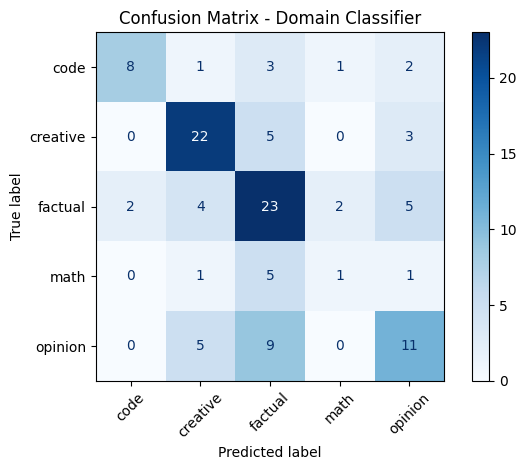

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(
    best_svm_oc, X_test_vec_oc, y_test_oc,
    display_labels=le.classes_,
    cmap='Blues',
    xticks_rotation=45
)
plt.title("Confusion Matrix - Domain Classifier")
plt.tight_layout()
plt.show()


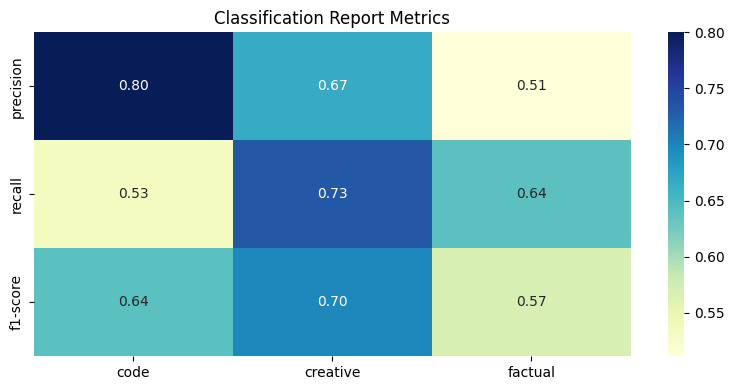

In [25]:
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

report = classification_report(y_test_oc, y_pred_oc, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report).iloc[:-1, :3] 

plt.figure(figsize=(8, 4))
sns.heatmap(report_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report Metrics")
plt.tight_layout()
plt.show()


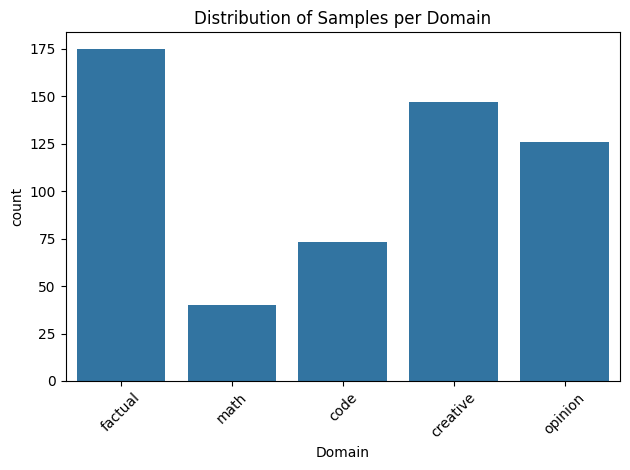

In [26]:
sns.countplot(x='Domain', data=df)
plt.title("Distribution of Samples per Domain")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


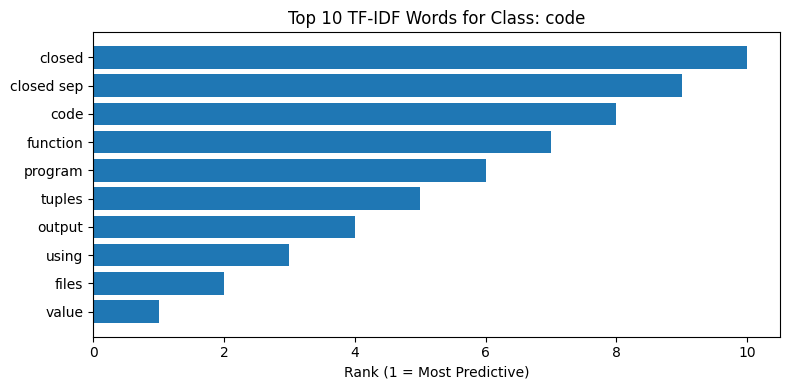

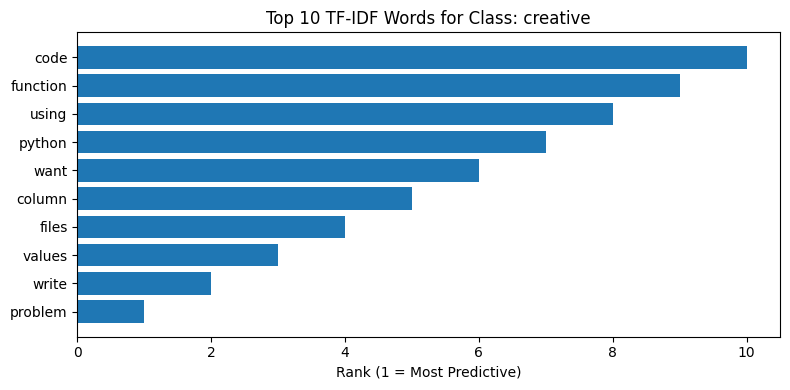

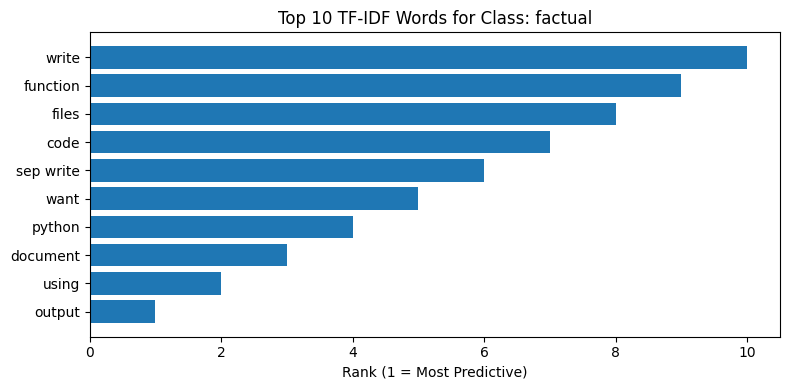

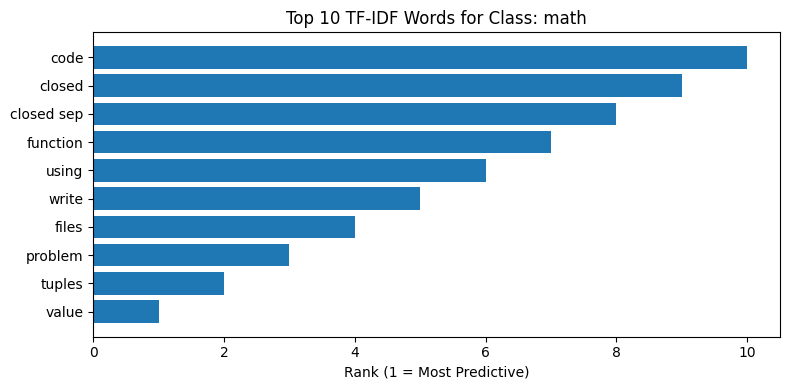

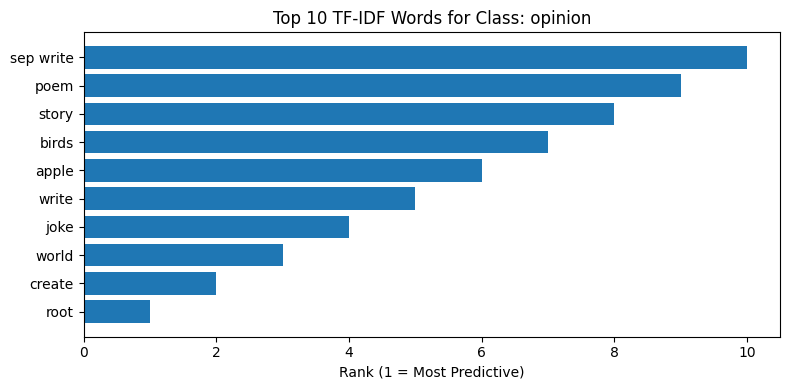

In [27]:
import matplotlib.pyplot as plt

top_words_dict = {
    'code': ['closed', 'closed sep', 'code', 'function', 'program', 'tuples', 'output', 'using', 'files', 'value'],
    'creative': ['code', 'function', 'using', 'python', 'want', 'column', 'files', 'values', 'write', 'problem'],
    'factual': ['write', 'function', 'files', 'code', 'sep write', 'want', 'python', 'document', 'using', 'output'],
    'math': ['code', 'closed', 'closed sep', 'function', 'using', 'write', 'files', 'problem', 'tuples', 'value'],
    'opinion': ['sep write', 'poem', 'story', 'birds', 'apple', 'write', 'joke', 'world', 'create', 'root']
}

for domain, words in top_words_dict.items():
    plt.figure(figsize=(8, 4))
    plt.barh(words[::-1], range(1, 11)) 
    plt.title(f"Top 10 TF-IDF Words for Class: {domain}")
    plt.xlabel("Rank (1 = Most Predictive)")
    plt.tight_layout()
    plt.show()


In [28]:
import streamlit
import joblib
joblib.dump(best_svm_oc, "best_svm_model.joblib")
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")
joblib.dump(le, "label_encoder.joblib")




['label_encoder.joblib']

In [29]:
import joblib
from dash import Dash, dcc, html, Input, Output

# Load trained model and associated vectorizer/encoder
model = joblib.load("best_svm_model.joblib")
vectorizer = joblib.load("tfidf_vectorizer.joblib")
label_encoder = joblib.load("label_encoder.joblib")

# Initialize Dash app
app = Dash(__name__)

app.layout = html.Div([
    html.H1("🤖 LLM Arena: Chatbot Domain Classifier", 
            style={"textAlign": "center", "fontFamily": "Arial", "marginTop": "30px"}),

    html.Div([
        dcc.Textarea(
            id='user_input',
            placeholder='💬 Type your prompt here...',
            style={
                'width': '100%',
                'height': '150px',
                'borderRadius': '10px',
                'padding': '10px',
                'fontSize': '16px',
                'fontFamily': 'Courier New',
                'boxShadow': '0 0 5px rgba(0,0,0,0.1)'
            }
        ),
        html.Button('🚀 Classify Domain', id='predict_button', n_clicks=0, 
                    style={
                        'marginTop': '10px',
                        'padding': '10px 20px',
                        'fontSize': '16px',
                        'borderRadius': '5px',
                        'backgroundColor': '#007BFF',
                        'color': 'white',
                        'border': 'none',
                        'cursor': 'pointer'
                    }),
        html.Div(id='prediction_output', 
                 style={
                     'marginTop': '20px', 
                     'fontWeight': 'bold',
                     'fontSize': '20px',
                     'color': '#2E8B57'
                 })
    ], style={
        'maxWidth': '700px', 
        'margin': 'auto', 
        'padding': '20px',
        'backgroundColor': '#F9F9F9',
        'borderRadius': '10px',
        'boxShadow': '0 0 10px rgba(0,0,0,0.05)'
    })
])


@app.callback(
    Output('prediction_output', 'children'),
    Input('predict_button', 'n_clicks'),
    Input('user_input', 'value')
)
def classify_domain(n_clicks, text):
    if n_clicks > 0 and text:
        X = vectorizer.transform([text])
        pred = model.predict(X)
        domain = label_encoder.inverse_transform(pred)[0]
        return f"Predicted Domain: {domain}"
    return ""

import os

if __name__ == '__main__':
    port = int(os.environ.get("PORT", 10000))  # Render sets PORT at runtime
    app.run_server(debug=False, host="0.0.0.0", port=port)
